In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers # type: ignore
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

 Load dataset


In [8]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4217 files belonging to 4 classes.


In [9]:
class_names = Dataset.class_names
class_names 

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [10]:
len(Dataset)

132

In [11]:
for image_batch, labels_batch in Dataset:
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 256, 256, 3)
[1 3 2 3 1 0 3 1 1 1 3 3 3 2 2 2 2 1 3 3 3 2 2 1 2 2 0 0 0 0 0 1]


In [12]:
for image_batch, labels_batch in Dataset:
    print(image_batch[0].numpy())

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  .

In [13]:
for image_batch, labels_batch in Dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


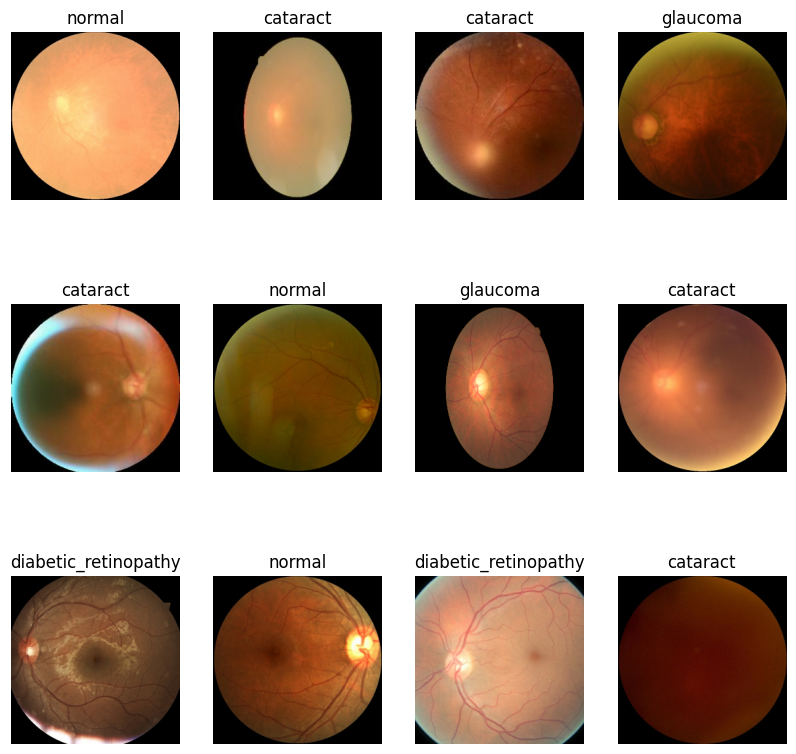

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in Dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
len(Dataset)

132

80% ==> training
20% ==> 10% validation, 10% test

In [16]:
train_size = 0.8
len(Dataset) * train_size


105.60000000000001

In [17]:
train_ds = Dataset.take(105)
len(train_ds)

105

In [18]:
test_ds = Dataset.skip(105)
len(test_ds)

27

In [19]:
val_size = 0.1
len(Dataset) * val_size

13.200000000000001

In [20]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [21]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(Dataset)

In [24]:
len(train_ds)

105

In [25]:
len(val_ds)

13

In [26]:
len(test_ds)

14

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [39]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),    
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64 , activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']    
    )

In [33]:
EPOCHS = 50

In [40]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.7221 - loss: 0.6659 - val_accuracy: 0.7404 - val_loss: 0.6248
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7368 - loss: 0.6596 - val_accuracy: 0.6851 - val_loss: 0.7509
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7560 - loss: 0.5804 - val_accuracy: 0.7500 - val_loss: 0.5673
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7601 - loss: 0.5643 - val_accuracy: 0.7740 - val_loss: 0.5311
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7891 - loss: 0.5369 - val_accuracy: 0.7909 - val_loss: 0.5592
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.7863 - loss: 0.5171 - val_accuracy: 0.8149 - val_loss: 0.4680
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.7931 - loss: 0.5223 - val_accuracy: 0.8077 - val_loss: 0.5262
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.7909 - loss: 0.5254 - val_accu

In [41]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 520ms/step - accuracy: 0.8913 - loss: 0.2756


In [42]:
scores

[0.3014025092124939, 0.8772321343421936]

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 105}

In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
history.history['accuracy']

[0.7116015553474426,
 0.7345660328865051,
 0.7458992004394531,
 0.7617059350013733,
 0.7757232189178467,
 0.7918282151222229,
 0.805249035358429,
 0.8025648593902588,
 0.8159856796264648,
 0.8201610445976257,
 0.8213540315628052,
 0.8267223238945007,
 0.8222487568855286,
 0.8395466804504395,
 0.8332836031913757,
 0.8338801264762878,
 0.8413361310958862,
 0.8416343331336975,
 0.8404414057731628,
 0.8464062213897705,
 0.844914972782135,
 0.8458096981048584,
 0.8535639643669128,
 0.8544586896896362,
 0.8520727753639221,
 0.8544586896896362,
 0.8613182306289673,
 0.8487921357154846,
 0.8502833247184753,
 0.8660900592803955,
 0.8651953339576721,
 0.8660900592803955,
 0.8663883209228516,
 0.8663883209228516,
 0.8589323163032532,
 0.875931978225708,
 0.867283046245575,
 0.8657918572425842,
 0.87384432554245,
 0.867283046245575,
 0.8675812482833862,
 0.8813003301620483,
 0.8720548748970032,
 0.8762302398681641,
 0.8845809698104858,
 0.8860721588134766,
 0.8702654242515564,
 0.8839845061302185,

In [46]:
len(history.history['accuracy'])

50

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

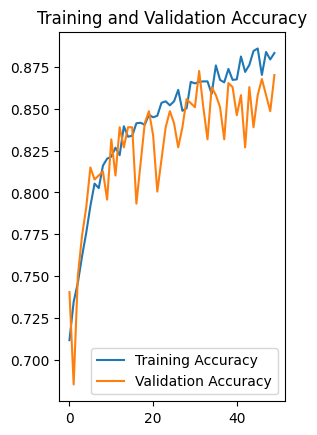

In [62]:
plt.subplot( 1, 2, 2)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

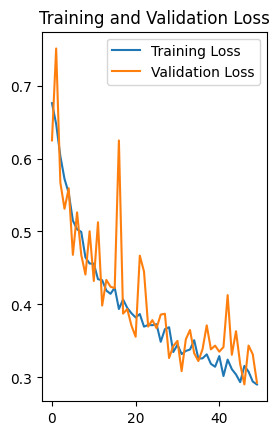

In [61]:
plt.subplot( 1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first_image to predict
Actual Label: diabetic_retinopathy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
predicted Label: diabetic_retinopathy


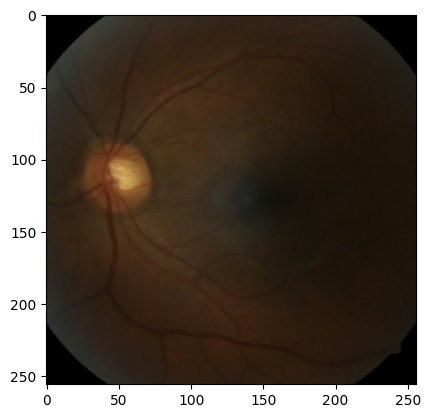

In [63]:
import numpy as np

for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()


    print("first_image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [64]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


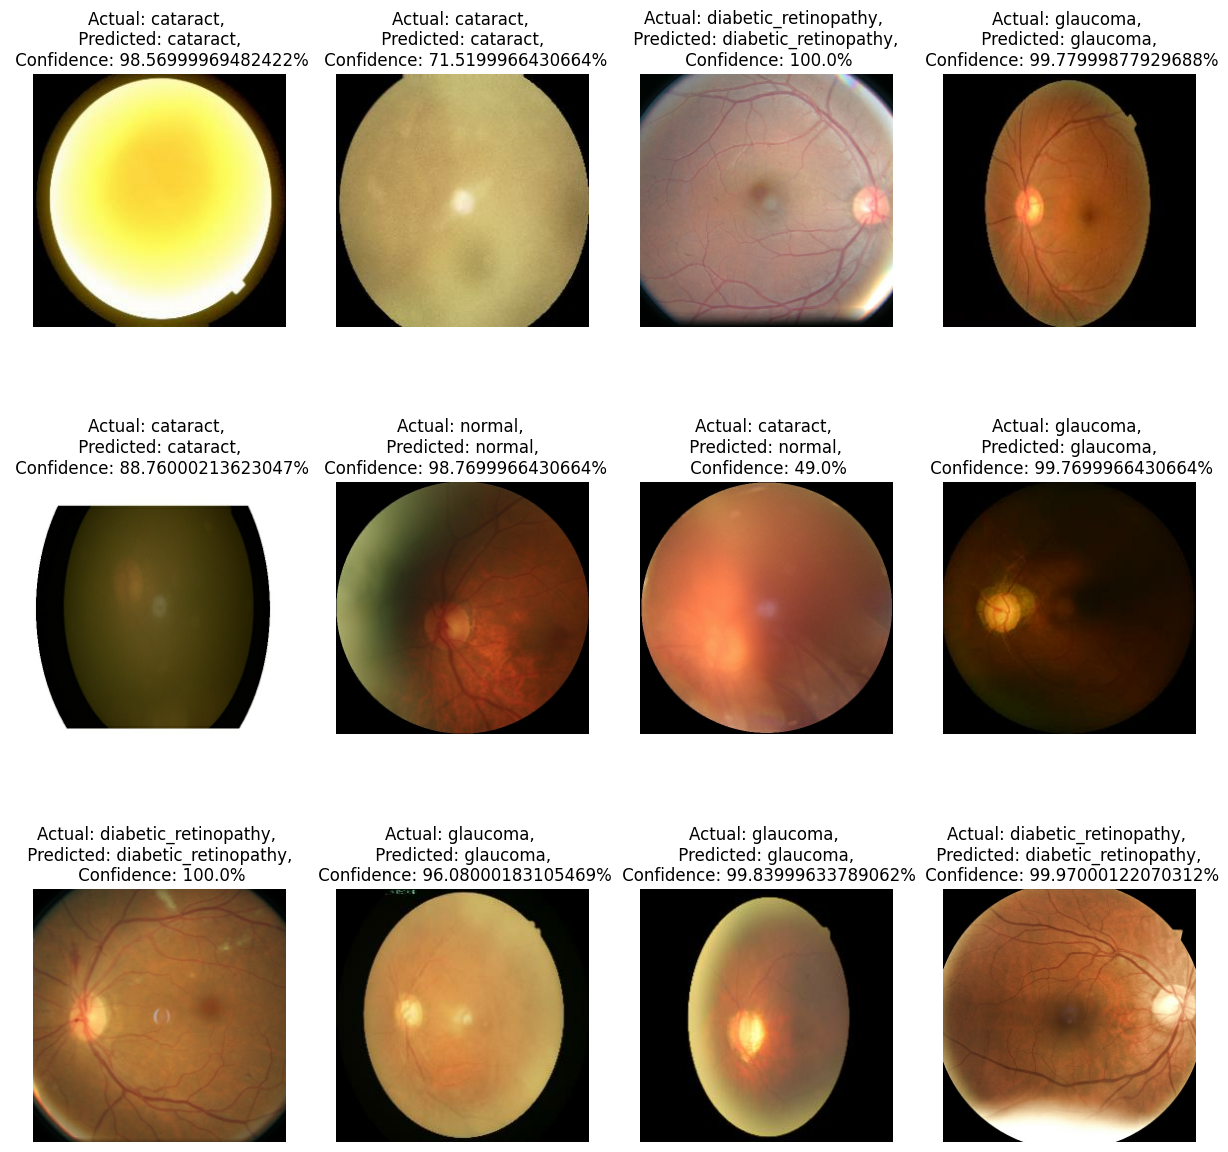

In [65]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")
        

In [71]:
import os
import re

def get_next_version_number(base_dir="../Models"):
    """Get the next version number in the sequence"""
    os.makedirs(base_dir, exist_ok=True)
    
    # Extract all numeric version numbers from filenames
    version_numbers = []
    for filename in os.listdir(base_dir):
        # Match files like "1.keras" or "2.h5" or directory "3" (for SavedModel)
        match = re.match(r'^(\d+)(?:\..+)?$', filename)
        if match:
            version_numbers.append(int(match.group(1)))
    
    return max(version_numbers + [0]) + 1

# Get the next version number
model_version = get_next_version_number()

# Save the model (choose one format)
model.save(f"../Models/{model_version}.keras")  # Recommended format

In [72]:
import os
import re

def save_model_version_h5(model, base_dir="../Models"):
    """
    Save model in .h5 format with automatic version numbering
    
    Args:
        model: Your trained Keras model
        base_dir: Directory to save models (default: "../Models")
    """
    # Create directory if it doesn't exist
    os.makedirs(base_dir, exist_ok=True)
    
    # Get existing version numbers from .h5 files
    version_numbers = []
    for filename in os.listdir(base_dir):
        if filename.endswith('.h5'):
            # Extract number from "1.h5", "2.h5" etc.
            try:
                version = int(filename.split('.')[0])
                version_numbers.append(version)
            except ValueError:
                continue  # Skip files that don't match our pattern
    
    # Determine next version number
    next_version = max(version_numbers + [0]) + 1
    
    # Save the model
    model_path = os.path.join(base_dir, f"{next_version}.h5")
    model.save(model_path)
    
    print(f"Model saved as version {next_version} at {model_path}")
    return model_path

# Usage example:
save_model_version_h5(model)  # Saves as "1.h5", "2.h5", etc.

Model saved as version 1 at ../Models\1.h5


'../Models\\1.h5'

In [73]:
import json
from datetime import datetime

def save_model_version_h5_with_metadata(model, base_dir="../Models"):
    """
    Save model in .h5 format with versioning and metadata
    """
    # Save the model
    model_path = save_model_version_h5(model, base_dir)
    version = int(os.path.basename(model_path).split('.')[0])
    
    # Create metadata
    metadata = {
        "version": version,
        "save_date": datetime.now().isoformat(),
        "model_summary": [],
        "input_shape": model.input_shape,
        "output_shape": model.output_shape,
        "training_metrics": {
            "accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1]
        }
    }
    
    # Capture model summary
    string_list = []
    model.summary(print_fn=lambda x: string_list.append(x))
    metadata["model_summary"] = "\n".join(string_list)
    
    # Save metadata
    metadata_path = os.path.join(base_dir, f"{version}_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return model_path

# Usage:
save_model_version_h5_with_metadata(model)

Model saved as version 2 at ../Models\2.h5


'../Models\\2.h5'

In [74]:
model.save("../eyedisease.h5")

In [78]:
model.save("../eyedisease.keras")

In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("keras_model.h5", compile=False)

# Load the labels
class_names = open("labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("129_right.jpeg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1997090281.py, line 9)